In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [49]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import app.eda as eda
from sklearn.metrics import roc_curve
import scikitplot as skplt
import datetime
from sklearn.model_selection import GridSearchCV
from time import time

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
pd.set_option("display.max_columns", 500)

In [51]:
#importing data
data = pd.read_json("data.json")

In [53]:
#Exporting some of the data to load in mongo
val_indx = random.sample(range(len(data)), 1000)
df_exp = data.iloc[val_indx,:]
data.drop(val_indx, inplace=True)

In [54]:
len(df_exp.columns)

44

In [55]:
df_exp.to_json("test_script_examples.json")
data.to_json("train_data.json")

In [56]:
len(data)

13337

In [57]:
data.head()

,acct_type,approx_payout_date,body_length,channels,country,currency,delivery_method,description,email_domain,event_created,event_end,event_published,event_start,fb_published,gts,has_analytics,has_header,has_logo,listed,name,name_length,num_order,num_payouts,object_id,org_desc,org_facebook,org_name,org_twitter,payee_name,payout_type,previous_payouts,sale_duration,sale_duration2,show_map,ticket_types,user_age,user_created,user_type,venue_address,venue_country,venue_latitude,venue_longitude,venue_name,venue_state
0,fraudster_event,1266062400,3852,5,US,USD,0.0,"<p><a href=""http://s432.photobucket.com/albums...",gmail.com,1262739706,1265630400,1.263110e+09,1265594400,0,0.00,0,1.0,0,y,"99 HOUR ""NO SLEEP"" SUPER BOWL CELEBRITY WEEKEN...",60,0,0,527017,,0.0,Party Starz Ent & Diverse Int'l Group,0.0,,,[],29.0,33,1,"[{'event_id': 527017, 'cost': 25.0, 'availabil...",36,1259613950,1,717 Washington Avenue,US,25.777471,-80.133433,INK Nightclub - South Beach,FL
1,premium,1296720000,3499,0,US,USD,1.0,"<p>Join us for a quick, one-night, community-b...",ruf.org,1293832670,1296288000,1.293833e+09,1296255600,0,868.02,0,0.0,1,n,Winthrop RUF Winter Getaway,27,23,1,786878,"<p>Since 1987, RUF has ministered to students ...",0.0,RUF at Winthrop University,12.0,RUF,CHECK,"[{'name': 'RUF', 'created': '2010-10-01 01:10:...",28.0,28,0,"[{'event_id': 786878, 'cost': 35.0, 'availabil...",149,1280942776,3,,US,32.776566,-79.930922,"The Charleston, SC area",SC
2,premium,1296172800,2601,8,US,USD,1.0,"<h3><span class=""subcategory""><strong>Teacher ...",pvsd.k12.ca.us,1291090956,1295740800,1.291092e+09,1295713800,0,3500.00,0,NaN,0,y,DRDP (2010) Teacher Training,28,19,4,787337,"<p><a href=""http://www.desiredresults.com"">www...",0.0,University Preparation School in collaboration...,0.0,University Preparation School,CHECK,"[{'name': 'Danielle Severn', 'created': '2010-...",54.0,54,0,"[{'event_id': 787337, 'cost': 93.51, 'availabi...",214,1272559388,3,10100 Pioneer Blvd Suite 100,US,33.944201,-118.080419,Los Angeles County Office of Education,CA
3,premium,1388966400,12347,6,IE,EUR,1.0,"<p style=""margin-bottom: 1.3em; padding-bottom...",irishtabletennis.com,1360681570,1388534400,1.360683e+09,1360702800,0,1167.35,0,0.0,1,y,ITTA Affiliation 2013,21,39,16,885645,,0.0,,0.0,,ACH,"[{'name': '', 'created': '2010-11-09 01:10:15'...",0.0,0,0,"[{'event_id': 885645, 'cost': 25.0, 'availabil...",889,1283870102,3,,None,NaN,NaN,None,None
4,premium,1297900800,2417,11,US,USD,0.0,<p>Writers and filmmakers need to understand t...,artsandbusinesscouncil.org,1291994666,1297468800,1.291995e+09,1297440000,1,2313.15,0,0.0,0,y,Self Defense for Writers and Filmmakers: For A...,66,30,0,1114349,"<p><font face=""Arial""><font size=""2""><strong>T...",0.0,Arts & Business Council of Greater Boston,0.0,Arts and Business Council or Greater Boston,CHECK,[{'name': 'Arts and Business Council or Greate...,63.0,63,0,"[{'event_id': 1114349, 'cost': 150.0, 'availab...",35,1288984065,3,One Marina Park Drive,US,42.353848,-71.044276,Fish & Richardson,MA


In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13337 entries, 0 to 14336
Data columns (total 44 columns):
acct_type             13337 non-null object
approx_payout_date    13337 non-null int64
body_length           13337 non-null int64
channels              13337 non-null int64
country               13263 non-null object
currency              13337 non-null object
delivery_method       13324 non-null float64
description           13337 non-null object
email_domain          13337 non-null object
event_created         13337 non-null int64
event_end             13337 non-null int64
event_published       13250 non-null float64
event_start           13337 non-null int64
fb_published          13337 non-null int64
gts                   13337 non-null float64
has_analytics         13337 non-null int64
has_header            8306 non-null float64
has_logo              13337 non-null int64
listed                13337 non-null object
name                  13337 non-null object
name_length      

In [59]:
# label = {'label':{'fraudster_event': True, 'premium': False, 'spammer_warn': False, 'fraudster': True,
#        'spammer_limited': False, 'spammer_noinvite': False, 'locked': False, 'tos_lock': False,
#        'tos_warn': False, 'fraudster_att': True, 'spammer_web': False, 'spammer': False}, 'listed': {'y': 1, 'n': 0}, "payout_type": {"": "undefined"}}


In [60]:
# columns=['approx_payout_date','country','description', 'email_domain','event_created','event_end',
#                  'event_published','event_start', 'name', 'object_id','org_desc',
#                 'org_name', 'payee_name', 'previous_payouts', 'ticket_types','user_created','user_type', 'venue_address', 'venue_country',
#                    'venue_latitude', 'venue_longitude', 'venue_name', 'venue_state','has_header']


In [61]:
df = eda.clean_data(data)

In [62]:
df.head()

,label,body_length,channels,delivery_method,fb_published,gts,has_analytics,has_logo,listed,name_length,num_order,num_payouts,org_facebook,org_twitter,sale_duration,sale_duration2,show_map,user_age,sold,currency_AUD,currency_CAD,currency_EUR,currency_GBP,currency_MXN,currency_NZD,currency_USD,payout_type_ACH,payout_type_CHECK,payout_type_undefined,public_domain_False,public_domain_True
0,True,3852,5,0.0,0,0.00,0,0,1,60,0,0,0.0,0.0,29.0,33,1,36,0,0,0,0,0,0,0,1,0,0,1,0,1
1,False,3499,0,1.0,0,868.02,0,1,0,27,23,1,0.0,12.0,28.0,28,0,149,25,0,0,0,0,0,0,1,0,1,0,1,0
2,False,2601,8,1.0,0,3500.00,0,0,1,28,19,4,0.0,0.0,54.0,54,0,214,48,0,0,0,0,0,0,1,0,1,0,1,0
3,False,12347,6,1.0,0,1167.35,0,1,1,21,39,16,0.0,0.0,0.0,0,0,889,58,0,0,1,0,0,0,0,1,0,0,1,0
4,False,2417,11,0.0,1,2313.15,0,0,1,66,30,0,0.0,0.0,63.0,63,0,35,39,0,0,0,0,0,0,1,0,1,0,1,0


In [63]:
y = df.pop("label").values
X = df.values

In [64]:
X.shape

(13150, 30)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [66]:
#first out of the bag model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_predict = rf.predict(X_test)

In [67]:
#confusion matrix
precision, recall, accuracy, matrix = eda.metrics(y_test, y_predict)

In [68]:
matrix

array([[ 232,   11],
       [  34, 3011]])

In [69]:
print("Recall: {}".format(round(recall,2)))
print("Precision: {}".format(round(precision,2)))
print("Accuracy: {}".format(round(accuracy*100,2)))

Recall: 0.87
Precision: 0.95
Accuracy: 98.63


In [70]:
#predicted probabilities
scores = rf.predict_proba(X_test)

In [71]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, scores[:,1], pos_label=1)

In [72]:
scores[:,1]

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

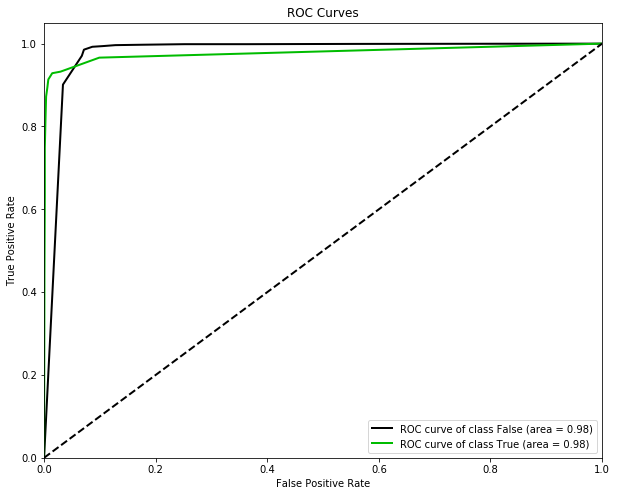

In [73]:
_=skplt.metrics.plot_roc(y_test, scores, plot_micro=False, plot_macro=False, figsize=(10,8))

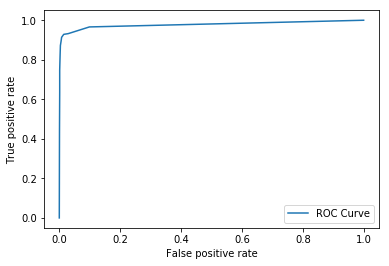

In [74]:
#Plotting the ROC curve
plt.plot(fpr,tpr, label="ROC Curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend()
plt.show()

In [75]:
# df["event_start"]=df["event_start"].map(lambda x: datetime.datetime.fromtimestamp(x).strftime("%Y-%m-%d %H:%M:%S"))

In [76]:
# df["approx_payout_date_date"]=df["approx_payout_date"].map(lambda x: x.split(" ")[0])
# df["approx_payout_date_hour"]=df["approx_payout_date"].map(lambda x: int(x.split(" ")[1].split(":")[0]))



In [77]:
# use a full grid over all parameters
param_grid = {"n_estimators": [180],
              "max_depth": [30],
              "max_features": [5],
              "min_samples_split": [4],
              "min_samples_leaf": [2],
              "criterion": ["gini"]}

# run grid search
start = time()
grid_search = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, n_jobs=-1)

grid_search.fit(X_train, y_train)
end = time()

In [78]:
print("Run time: {}s".format(round(end - start, 2)))

Run time: 3.9s


In [79]:
#Checking to see estimators with best results
rf2 = grid_search.best_estimator_
rf2

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=180, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [80]:
#creating prediction
y_pred = rf2.predict(X_test)

In [81]:
#confusion matrix
precision, recall, accuracy, matrix = eda.metrics(y_test, y_pred)

In [82]:
matrix

array([[ 233,   11],
       [  33, 3011]])

In [83]:
print("Recall: {}".format(round(recall,2)))
print("Precision: {}".format(round(precision,2)))
print("Accuracy: {}".format(round(accuracy*100,2)))

Recall: 0.88
Precision: 0.95
Accuracy: 98.66


In [84]:
#predicted probabilities
scores = rf2.predict_proba(X_test)

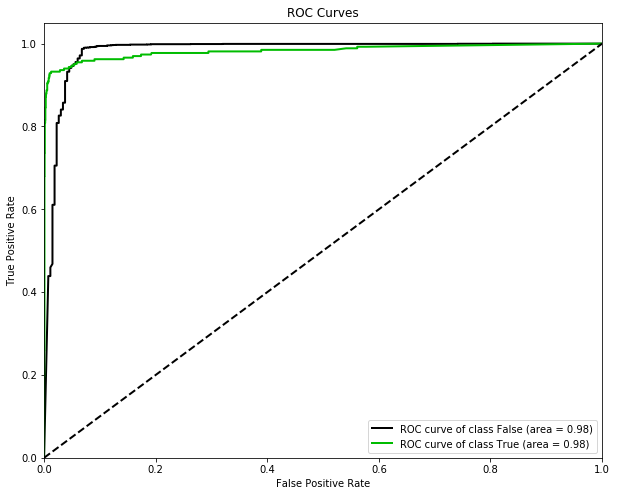

In [85]:
_=skplt.metrics.plot_roc(y_test, scores, plot_micro=False, plot_macro=False, figsize=(10,8))